In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

case_pqtl_path = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_known_loci/known_pro_assoc/06.pqtl/CTEPH_pqtl_result.pkl"
control_pqtl_path = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_known_loci/known_pro_assoc/06.pqtl/NAGA_pqtl_result.pkl"

case_pqtl = pd.read_pickle(case_pqtl_path)
control_pqtl = pd.read_pickle(control_pqtl_path)

In [10]:
model = "recessive"

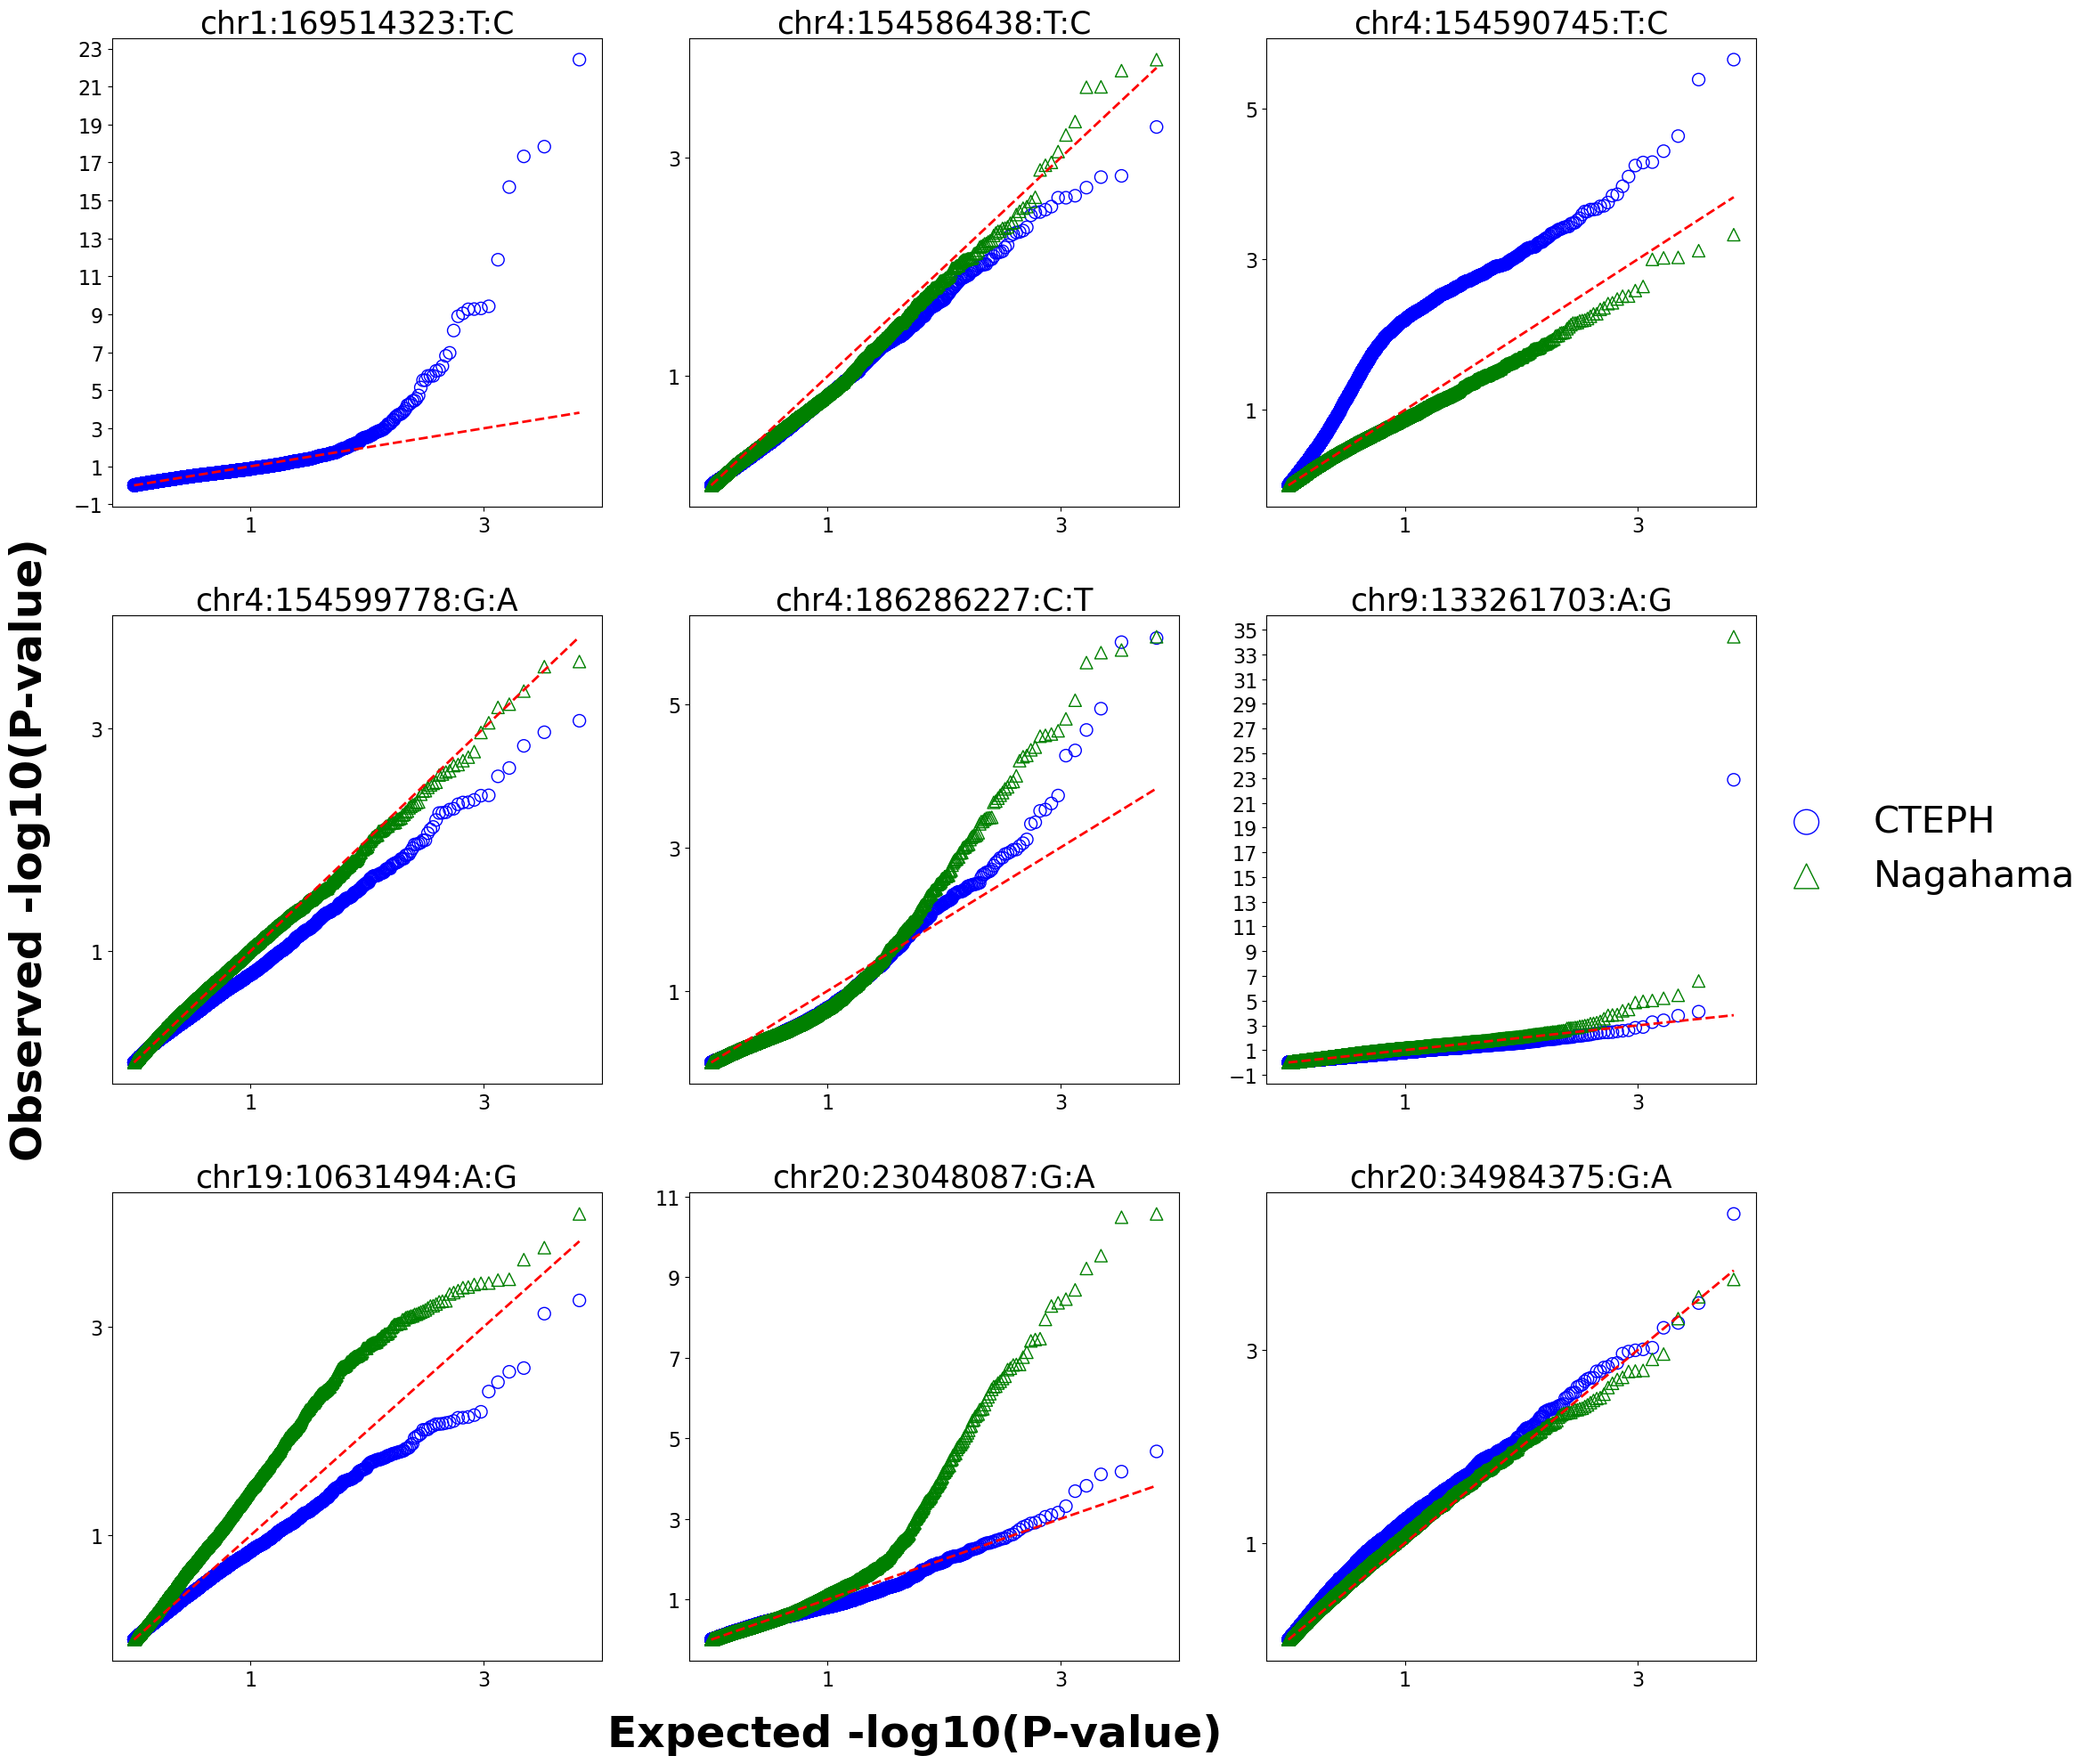

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FixedLocator

plt.style.use('default')  # Set the style of the plot

def qqplot(pvalues_case, pvalues_control, ax, label):
    # Case QQ plot
    sorted_pval_case = np.sort(pvalues_case)
    expected_case = -np.log10(np.linspace(1/len(sorted_pval_case), 1, len(sorted_pval_case)))
    observed_case = -np.log10(sorted_pval_case)
    
    # Control QQ plot
    sorted_pval_control = np.sort(pvalues_control)
    expected_control = -np.log10(np.linspace(1/len(sorted_pval_control), 1, len(sorted_pval_control)))
    observed_control = -np.log10(sorted_pval_control)
    
    # Plotting on the given axis
    ax.scatter(expected_case, observed_case, edgecolor='blue', facecolors='none', marker='o', label='CTEPH', s=100)
    ax.scatter(expected_control, observed_control, edgecolor='green', facecolors='none', marker='^', label='Nagahama', s=100)
    ax.plot([min(expected_case.min(), expected_control.min()), max(expected_case.max(), expected_control.max())], 
             [min(expected_case.min(), expected_control.min()), max(expected_case.max(), expected_control.max())], 
             'r--', linewidth=2)
    ax.set_title(f'{label}', fontsize=25, transform=ax.transAxes, verticalalignment='top')  # Title at top center
    
    # Set title to the top-left
    # ax.text(0.05, 0.95, label, transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=25, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='none'))
    
    # Adjust x and y ticks to show only odd integers
    odd_ticks_x = [x for x in range(int(ax.get_xlim()[0]), int(ax.get_xlim()[1])+1) if x % 2 != 0]
    odd_ticks_y = [y for y in range(int(ax.get_ylim()[0]), int(ax.get_ylim()[1])+1) if y % 2 != 0]
    ax.xaxis.set_major_locator(FixedLocator(odd_ticks_x))
    ax.yaxis.set_major_locator(FixedLocator(odd_ticks_y))
    ax.tick_params(axis='both', which='major', labelsize=16)  # Increase tick label size

# Create a 3x3 grid of subplots
keys = list(case_pqtl.keys())
fig, axes = plt.subplots(3, 3, figsize=(20, 20))  # Adjust for preferred figure size
axes = axes.flatten()  # Flatten the array to make indexing easier

for i, key in enumerate(keys):
    df_case = case_pqtl[key]
    df_control = control_pqtl[key]
    pvalues_case = df_case[f'{model}_pvalue'].values
    pvalues_control = df_control[f'{model}_pvalue'].values
    
    # Plot the QQ plot for the given key on the i-th axis
    qqplot(pvalues_case, pvalues_control, axes[i], key)

# Adjust layout and provide space for global axis labels
plt.tight_layout(pad=4.0)  # Increase padding to avoid clipping of tick labels

# Add a global legend
handles, labels = axes[-1].get_legend_handles_labels()  # Use the handles and labels from the last subplot
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.17, 0.5), frameon=False, fontsize=30, markerscale=2)  # Increase font size

# Add global X and Y labels more appropriately and adjust their position
fig.text(0.5, 0.003, 'Expected -log10(P-value)', ha='center', va='center', fontsize=35, weight='bold')  # Increase font size
fig.text(0.003, 0.5, 'Observed -log10(P-value)', ha='center', va='center', rotation='vertical', fontsize=35, weight='bold')  # Increase font size

plt.show()
